In [1]:
#!pip install -U transformers
#!pip install -U datasets
#!pip install optuna
import os
import sys
HOME = os.path.abspath('..')
sys.path.append(HOME)
os.chdir(HOME)
import pandas as pd
#!pip install transformers
from transformers import RobertaConfig, RobertaModel,RobertaForSequenceClassification, Trainer,AutoModelForSequenceClassification, EarlyStoppingCallback 
from transformers import AutoTokenizer
from transformers.models.roberta import RobertaPreTrainedModel
import torch
from torch import nn
from transformers import TrainingArguments
import glob
import optuna
from itertools import product
import numpy as np
from pprint import pprint
import csv
from transformers import set_seed
from sklearn.preprocessing import StandardScaler
from typing import Dict, List, Optional, Set, Tuple, Union
import matplotlib.pyplot as plt
from torchvision.transforms import transforms
from PIL import Image, ImageFilter
import random

In [2]:
MODEL_NAME =  "distilbert-base-uncased" #"roberta-base" 
TARGET_COL = 'averageRating'#'revenue_worldwide_BOM'
MODEL_FOLDER = 'everything_as_text_and_images'#'everything_as_text'
text_input_col = 'text_input'
CATEGORIES_AS_TEXT = True
NUMERIC_AS_TEXT = False
DATE_AS_TEXT = False
ADJUST_INFLATION = False
USE_COLUMN_NAMES = False
DEBUG = False
IMG_SIZE = 224

FINAL_MODEL_NAME = f"{MODEL_NAME}-{TARGET_COL}"

if ADJUST_INFLATION:
    FINAL_MODEL_NAME+='-inflation_adjusted'
    
if USE_COLUMN_NAMES:
    FINAL_MODEL_NAME+='-with_column_names'
    

FINAL_MODEL_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}'
TRIALS_DF_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_hparams_trials.csv'
TEST_PERFORMANCE_PATH = f'models/{MODEL_FOLDER}/{FINAL_MODEL_NAME}_test_stats_best_model.csv'
    
if USE_COLUMN_NAMES:
    assert CATEGORIES_AS_TEXT|NUMERIC_AS_TEXT|DATE_AS_TEXT, "can't use column names as text if there are no columns to treat as text!"
    
print('Final model name: ',FINAL_MODEL_NAME)
print('Saving at: ',MODEL_FOLDER)



Final model name:  distilbert-base-uncased-averageRating
Saving at:  everything_as_text_and_images


In [3]:
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True)


def read_images_split(split,path = 'data/processed/posters/',id_col="imdb_id"):
  split_images = []
  for row in split:

      name = f'{int(row)}.jpg'

      img_name = os.path.join(path,name)
        
      missing_image = plt.imread(os.path.join(path,'missing.jpg'))
    
      # Use you favourite library to load the image
      try:
        image = plt.imread(img_name)

      except FileNotFoundError:
        image = missing_image
        
      if len(image.shape)==2:
        image = np.repeat(np.expand_dims(image,-1),3,-1)
    
      split_images.append(image)
        
  return split_images


class IMDbDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, transform):
        self.encodings = encodings
        self.labels = labels
        self.transform = transform

    def __getitem__(self, idx):
        
        item = {}
        item['labels'] = torch.tensor(self.labels[idx])
        for key, val in self.encodings.items():
            
            if key == 'images':
                item['images'] = Image.fromarray(val[idx].astype(np.uint8))
                item['images'] = self.transform(item['images'])
            else:
                item[key] = torch.tensor(val[idx])
        
        return item
    
    def __len__(self):
        return len(self.labels)

def process_text_data(data_:pd.DataFrame,text_col,padding ="max_length", truncation = True, na_filler = ""):

    '''
    
    '''
    data = data_.copy()
    data[text_col] = data[text_col].fillna(na_filler)
    encodings = tokenizer(data[text_col].tolist(), padding=padding, truncation=truncation)
    return encodings
    

def columns_to_single_text(df,
                           cols_to_transform,
                           new_col_name = 'text_input',
                           sep = tokenizer.sep_token,
                           nan_replacement = tokenizer.unk_token ):

  '''
  
  Creates a new column called new_col_name with with all columns in cols_to_transform concatenated into a single text
  '''
  df[new_col_name] = df[cols_to_transform].astype(str).replace('nan',nan_replacement).agg(f' {sep} '.join, axis=1)


class NAFiller:

  def __init__(self,train):
    self.train = train

  def fit(self,column = 'Budget',groupby=['top_genre','top_country']):
    self.mapping = self.train.groupby(groupby)[column].median().reset_index()
    self.mapping = self.mapping.rename(columns={column:'na_filler'})
    self.median = self.train[column].median()
    self.column=column


  def transform(self,test,round = False):
    self.na_filler = test.merge(self.mapping,how='left')['na_filler']
    self.na_filler = self.na_filler.fillna(self.median)

    test[self.column] = test[self.column].reset_index(drop=True).fillna(self.na_filler).values

    if round:
      test[self.column] = test[self.column].round().astype(int)
      


  def fit_transform(self,test,column = 'Budget',groupby=['top_genre','top_country']):
    self.fit(column,groupby)
    self.transform()
    self.column=column
        

def create_dataset_split(split,
                         text_cols,
                         text_input_col,
                         TARGET_COL,
                         transform,
                         numeric_cols = [],
                         images = None,
                         new_col_name = 'text_input',
                         sep = tokenizer.sep_token,
                         nan_replacement = tokenizer.unk_token):
    
  if TARGET_COL == 'revenue_worldwide_BOM':
    split[TARGET_COL] = np.log1p(split[TARGET_COL])
    print('log transforming target')

  #If all columns in text_cols are combined into a single text. A n
  columns_to_single_text(split,text_cols)

  #Get split encodings
  split_encodings = process_text_data(split,text_input_col)
    
  if numeric_cols:
    split_encodings['numeric_features'] = split[numeric_cols].values.tolist()
    
  if images:
    split_encodings['images'] = images
    
    
  #get labels
  split_labels = split[TARGET_COL].tolist()

  #Create dataset objects
  split_dataset = IMDbDataset(split_encodings, split_labels,transform)

  return split_dataset

def date_to_season(doy):
    doy = doy.dayofyear
    # "day of year" ranges for the northern hemisphere
    spring = range(80, 172)
    summer = range(172, 264)
    fall = range(264, 355)
    # winter = everything else

    if doy in spring:
      season = 1 #'spring'
    elif doy in summer:
      season = 2 #'summer'
    elif doy in fall:
      season = 3 #'fall'
    else:
      season = 4 #'winter'
    return season

def cyclical_encoding(data, col, max_val, min_val = 1, drop = True):
    """Encoding of cyclical features using sine and cosine transformation.
    Examples of cyclical features are: hour of day, month, day of week.

    :param df: A dataframe containing the column we want to encode
    :type df: :py:class:`pandas.DataFrame`
    :param col: The name of the column we want to encode.
    :type col: str
    :param max_val: The maximum value the variable can have. e.g. in hour of day, max value = 23
    :type max_val: int
    :param min_val: The minimum value the variable can have. e.g. in hour of day, min value = 1, defaults to 1
    :type min_val: int
    :return: dataframe with three new variables: sine and cosine of the features + the multiplicationof these two columns
    :rtype: :py:class:`pandas.DataFrame`
    """

    data[col] = data[col] - min_val #ensure min value is 0
    data[col + '_sin'] = np.sin(2 * np.pi * data[col] / max_val)
    data[col + '_cos'] = np.cos(2 * np.pi * data[col] / max_val)

    if drop:
        data.drop(col,axis=1,inplace=True)


In [4]:
from torchvision.transforms import RandAugment

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x
    
all_cols =  ['Budget',
             'averageRating',
             'cast',
             'countries',
             'director',
             'genres',
             'imdb_id',
             'languages',
             'overview',
             'production companies',
             'release_date',
             'revenue_worldwide_BOM',
             'runtimeMinutes',
             'title']



transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

transform_train_augmented  =  transforms.Compose([
    transforms.RandomResizedCrop(size=IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomRotation(degrees=15),
    transforms.RandomApply([
            transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)  # not strengthened
        ], p=0.8),
    transforms.RandomGrayscale(p=0.2),
    transforms.RandomHorizontalFlip(),
    transforms.RandomApply([GaussianBlur([.1, 2.])], p=0.5),
    #RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

    

#Train/test transforms
transform_test = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
    
    
    
train_ids = pd.read_csv('data/processed/train.csv',usecols=['imdb_id'])['imdb_id'].tolist()
val_ids = pd.read_csv('data/processed/val.csv',usecols=['imdb_id'])['imdb_id'].tolist()
test_ids = pd.read_csv('data/processed/test.csv',usecols=['imdb_id'])['imdb_id'].tolist()
df = pd.read_csv('data/processed/df.csv',usecols = all_cols,parse_dates=['release_date']).sample(frac=1,random_state=42) #shuffle



#Additional auxilary columns
df['top_genre'] = df['genres'].apply(lambda x: x.split(', ')[0])
df['top_country'] = df['countries'].apply(lambda x: x.split(', ')[0] if isinstance(x,str) else x)


categoric_cols = ['cast',
                  'countries',
                  'director',
                  'genres',
                  'languages',
                  'production companies']

text_cols = ['title','overview']                  
date_cols = ['release_date']

if (not DATE_AS_TEXT): #If date is not as text, include numeri date features
    df['year'] = df['release_date'].dt.year
    df['month'] = df['release_date'].dt.month
    df['day'] = df['release_date'].dt.day


    
df[categoric_cols] = df[categoric_cols].apply(lambda x: x.str.replace('|',', '),axis=0) #Change pipe to comma, its more meaningful
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'],errors='coerce')


numeric_cols = list(df.dtypes.index[(df.dtypes == int)|(df.dtypes == float)].drop(['imdb_id',
                                                                              'averageRating',
                                                                              'revenue_worldwide_BOM']))



if CATEGORIES_AS_TEXT:
  text_cols+=categoric_cols

if NUMERIC_AS_TEXT:
  text_cols+=numeric_cols

if DATE_AS_TEXT:
  text_cols+=date_cols



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:91: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.


In [5]:
#Create splits
if DEBUG:
    train = df[df['imdb_id'].isin(train_ids)].sample(frac=0.2)
    val = df[df['imdb_id'].isin(val_ids)].sample(frac=0.2)
    test = df[df['imdb_id'].isin(test_ids)]
else:
    train = df[df['imdb_id'].isin(train_ids)]
    val = df[df['imdb_id'].isin(val_ids)]
    test = df[df['imdb_id'].isin(test_ids)]

    
#Get images per split
train_images = read_images_split(train['imdb_id'].tolist())
val_images = read_images_split(val['imdb_id'].tolist())
test_images = read_images_split(test['imdb_id'].tolist())


#Fill na in some columns with statistics
naf = NAFiller(train)
sc = StandardScaler()

cols_to_impute = [i for i in numeric_cols if ('cos' not in i)&('sin' not in i)]
    
for col in cols_to_impute:
    naf.fit(column = col,groupby=['top_genre','top_country'])
    naf.transform(train,round=True)
    naf.transform(val,round=True)
    naf.transform(test,round=True)

if not NUMERIC_AS_TEXT:
    train[numeric_cols] = sc.fit_transform(train[numeric_cols])
    val[numeric_cols] = sc.transform(val[numeric_cols])
    test[numeric_cols] = sc.transform(test[numeric_cols])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/sta

In [6]:

numeric_cols = numeric_cols if not NUMERIC_AS_TEXT else []
train_dataset=create_dataset_split(train,text_cols,text_input_col,TARGET_COL,transform_train,numeric_cols,images = train_images)
train_dataset_augmented=create_dataset_split(train,text_cols,text_input_col,TARGET_COL,transform_train_augmented,numeric_cols,images = train_images)

val_dataset=create_dataset_split(val,text_cols,text_input_col,TARGET_COL,transform_test,numeric_cols,images = val_images)
test_dataset=create_dataset_split(test,text_cols,text_input_col,TARGET_COL,transform_test,numeric_cols,images = test_images)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
from torchvision import models

In [8]:
class TabularConfig:
    r""" Config used for tabular combiner
    Args:
        mlp_division (int): how much to decrease each MLP dim for each additional layer
        combine_feat_method (str): The method to combine categorical and numerical features.
            See :obj:`TabularFeatCombiner` for details on the supported methods.
        mlp_dropout (float): dropout ratio used for MLP layers
        numerical_bn (bool): whether to use batchnorm on numerical features
        use_simple_classifier (bool): whether to use single layer or MLP as final classifier
        mlp_act (str): the activation function to use for finetuning layers
        gating_beta (float): the beta hyperparameters used for gating tabular data
            see the paper `Integrating Multimodal Information in Large Pretrained Transformers <https://www.aclweb.org/anthology/2020.acl-main.214.pdf>`_ for details
        numerical_feat_dim (int): the number of numerical features
        cat_feat_dim (int): the number of categorical features
    """
    def __init__(self,
                 num_labels,
                 mlp_division=4,
                 combine_feat_method='text_only',
                 mlp_dropout=0.1,
                 numerical_bn=True,
                 use_simple_classifier=True,
                 mlp_act='relu',
                 gating_beta=0.2,
                 numerical_feat_dim=0,
                 cat_feat_dim=0,
                 **kwargs
                 ):
        self.mlp_division = mlp_division
        self.combine_feat_method = combine_feat_method
        self.mlp_dropout = mlp_dropout
        self.numerical_bn = numerical_bn
        self.use_simple_classifier = use_simple_classifier
        self.mlp_act = mlp_act
        self.gating_beta = gating_beta
        self.numerical_feat_dim = numerical_feat_dim
        self.cat_feat_dim = cat_feat_dim
        self.num_labels = num_labels
        
import math
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss, MSELoss


class MLP(nn.Module):
    """mlp can specify number of hidden layers and hidden layer channels"""

    def __init__(self, input_dim, output_dim, act='relu', num_hidden_lyr=2,
                 dropout_prob=0.5, return_layer_outs=False,
                 hidden_channels=None, bn=False):
        super().__init__()
        self.out_dim = output_dim
        self.dropout = nn.Dropout(dropout_prob)
        self.return_layer_outs = return_layer_outs
        if not hidden_channels:
            hidden_channels = [input_dim for _ in range(num_hidden_lyr)]
        elif len(hidden_channels) != num_hidden_lyr:
            raise ValueError(
                "number of hidden layers should be the same as the lengh of hidden_channels")
        self.layer_channels = [input_dim] + hidden_channels + [output_dim]
        self.act_name = act
        self.activation = create_act(act)
        self.layers = nn.ModuleList(list(
            map(self.weight_init, [nn.Linear(self.layer_channels[i], self.layer_channels[i + 1])
                                   for i in range(len(self.layer_channels) - 2)])))
        final_layer = nn.Linear(self.layer_channels[-2], self.layer_channels[-1])
        self.weight_init(final_layer,   activation='linear')
        self.layers.append(final_layer)

        self.bn = bn
        if self.bn:
            self.bn = nn.ModuleList([torch.nn.BatchNorm1d(dim) for dim in self.layer_channels[1:-1]])

    def weight_init(self, m, activation=None):
        if activation is None:
            activation = self.act_name
        torch.nn.init.xavier_uniform_(m.weight, gain=nn.init.calculate_gain(activation))
        return m

    def forward(self, x):
        """
        :param x: the input features
        :return: tuple containing output of MLP,
                and list of inputs and outputs at every layer
        """
        layer_inputs = [x]
        for i, layer in enumerate(self.layers):
            input = layer_inputs[-1]
            if layer == self.layers[-1]:
                layer_inputs.append(layer(input))
            else:
                if self.bn:
                    output = self.activation(self.bn[i](layer(input)))
                else:
                    output = self.activation(layer(input))
                layer_inputs.append(self.dropout(output))

        # model.store_layer_output(self, layer_inputs[-1])
        if self.return_layer_outs:
            return layer_inputs[-1], layer_inputs
        else:
            return layer_inputs[-1]


def calc_mlp_dims(input_dim, division=2, output_dim=1):
    dim = input_dim
    dims = []
    while dim > output_dim:
        dim = dim // division
        dims.append(int(dim))
    dims = dims[:-1]
    return dims


def create_act(act, num_parameters=None):
    if act == 'relu':
        return nn.ReLU()
    elif act == 'prelu':
        return nn.PReLU(num_parameters)
    elif act == 'sigmoid':
        return nn.Sigmoid()
    elif act == 'tanh':
        return nn.Tanh()
    elif act == 'linear':
        class Identity(nn.Module):
            def forward(self, x):
                return x

        return Identity()
    else:
        raise ValueError('Unknown activation function {}'.format(act))


def glorot(tensor):
    stdv = math.sqrt(6.0 / (tensor.size(-2) + tensor.size(-1)))
    if tensor is not None:
        tensor.data.uniform_(-stdv, stdv)


def zeros(tensor):
    if tensor is not None:
        tensor.data.fill_(0)


In [9]:
import torch
from torch import nn
import torch.nn.functional as F

# from .layer_utils import calc_mlp_dims, create_act, glorot, zeros, MLP


class TabularFeatCombiner(nn.Module):
    r"""
        Combiner module for combining text features with categorical and numerical features
        The methods of combining, specified by :obj:`tabular_config.combine_feat_method` are shown below.
        :math:`\mathbf{m}` denotes the combined multimodal features,
        :math:`\mathbf{x}` denotes the output text features from the transformer,
        :math:`\mathbf{c}` denotes the categorical features, :math:`\mathbf{t}` denotes the numerical features,
        :math:`h_{\mathbf{\Theta}}` denotes a MLP parameterized by :math:`\Theta`, :math:`W` denotes a weight matrix,
        and :math:`b` denotes a scalar bias
        - **text_only**
            .. math::
                \mathbf{m} = \mathbf{x}
        - **concat**
            .. math::
                \mathbf{m} = \mathbf{x} \, \Vert \, \mathbf{c} \, \Vert \, \mathbf{n}
        - **mlp_on_categorical_then_concat**
            .. math::
                \mathbf{m} = \mathbf{x} \, \Vert \, h_{\mathbf{\Theta}}( \mathbf{c}) \, \Vert \, \mathbf{n}
        - **individual_mlps_on_cat_and_numerical_feats_then_concat**
            .. math::
                \mathbf{m} = \mathbf{x} \, \Vert \, h_{\mathbf{\Theta_c}}( \mathbf{c}) \, \Vert \, h_{\mathbf{\Theta_n}}(\mathbf{n})
        - **mlp_on_concatenated_cat_and_numerical_feats_then_concat**
            .. math::
                \mathbf{m} = \mathbf{x} \, \Vert \, h_{\mathbf{\Theta}}( \mathbf{c} \, \Vert \, \mathbf{n})
        - **attention_on_cat_and_numerical_feats** self attention on the text features
            .. math::
                \mathbf{m} = \alpha_{x,x}\mathbf{W}_x\mathbf{x} + \alpha_{x,c}\mathbf{W}_c\mathbf{c} + \alpha_{x,n}\mathbf{W}_n\mathbf{n}
          where :math:`\mathbf{W}_x` is of shape :obj:`(out_dim, text_feat_dim)`,
          :math:`\mathbf{W}_c` is of shape :obj:`(out_dim, cat_feat_dim)`,
          :math:`\mathbf{W}_n` is of shape :obj:`(out_dim, num_feat_dim)`, and the attention coefficients :math:`\alpha_{i,j}` are computed as
            .. math::
                \alpha_{i,j} =
                \frac{
                \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
                [\mathbf{W}_i\mathbf{x}_i \, \Vert \, \mathbf{W}_j\mathbf{x}_j]
                \right)\right)}
                {\sum_{k \in \{ x, c, n \}}
                \exp\left(\mathrm{LeakyReLU}\left(\mathbf{a}^{\top}
                [\mathbf{W}_i\mathbf{x}_i \, \Vert \, \mathbf{W}_k\mathbf{x}_k]
                \right)\right)}.
        - **gating_on_cat_and_num_feats_then_sum** sum of features gated by text features. Inspired by the gating mechanism introduced in `Integrating Multimodal Information in Large Pretrained Transformers <https://www.aclweb.org/anthology/2020.acl-main.214.pdf>`_
            .. math::
                \mathbf{m}= \mathbf{x} + \alpha\mathbf{h}
            .. math::
                \mathbf{h} = \mathbf{g_c} \odot (\mathbf{W}_c\mathbf{c}) + \mathbf{g_n} \odot (\mathbf{W}_n\mathbf{n}) + b_h
            .. math::
                \alpha = \mathrm{min}( \frac{\| \mathbf{x} \|_2}{\| \mathbf{h} \|_2}*\beta, 1)
          where :math:`\beta` is a hyperparamter, :math:`\mathbf{W}_c` is of shape :obj:`(out_dim, cat_feat_dim)`,
          :math:`\mathbf{W}_n` is of shape :obj:`(out_dim, num_feat_dim)`. and the gating vector :math:`\mathbf{g}_i` with activation function :math:`R` is defined as
            .. math::
                \mathbf{g}_i = R(\mathbf{W}_{gi}[\mathbf{i} \, \Vert \, \mathbf{x}]+ b_i)
          where :math:`\mathbf{W}_{gi}` is of shape :obj:`(out_dim, i_feat_dim + text_feat_dim)`
        - **weighted_feature_sum_on_transformer_cat_and_numerical_feats**
            .. math::
                \mathbf{m} = \mathbf{x} + \mathbf{W}_{c'} \odot \mathbf{W}_c \mathbf{c} + \mathbf{W}_{n'} \odot \mathbf{W}_n \mathbf{t}
       Parameters:
           tabular_config (:class:`~multimodal_config.TabularConfig`):
               Tabular model configuration class with all the parameters of the model.
       """
    def __init__(self, tabular_config):
        super().__init__()
        


        self.combine_feat_method = tabular_config.combine_feat_method
        self.cat_feat_dim = tabular_config.cat_feat_dim
        self.numerical_feat_dim = tabular_config.numerical_feat_dim
        self.num_labels = tabular_config.num_labels
        self.numerical_bn = tabular_config.numerical_bn
        self.mlp_act = tabular_config.mlp_act
        self.mlp_dropout = tabular_config.mlp_dropout
        self.mlp_division = tabular_config.mlp_division
        self.text_out_dim = tabular_config.text_feat_dim
        self.tabular_config = tabular_config

        if self.numerical_bn and self.numerical_feat_dim > 0:
            self.num_bn = nn.BatchNorm1d(self.numerical_feat_dim)
        else:
            self.num_bn = None

        if self.combine_feat_method == 'text_only':
            self.final_out_dim = self.text_out_dim
        elif self.combine_feat_method == 'concat':
            self.final_out_dim = self.text_out_dim + self.cat_feat_dim \
                           + self.numerical_feat_dim
        elif self.combine_feat_method == 'mlp_on_categorical_then_concat':
            assert self.cat_feat_dim != 0, 'dimension of cat feats should not be 0'
            # reduce dim of categorical features to same of num dim or text dim if necessary
            output_dim = min(self.text_out_dim,
                             max(self.numerical_feat_dim, self.cat_feat_dim // (self.mlp_division // 2)))
            dims = calc_mlp_dims(
                self.cat_feat_dim,
                self.mlp_division,
                output_dim
            )
            self.cat_mlp = MLP(
                self.cat_feat_dim,
                output_dim,
                act=self.mlp_act,
                num_hidden_lyr=len(dims),
                dropout_prob=self.mlp_dropout,
                hidden_channels=dims,
                return_layer_outs=False,
                bn=True
            )
            self.final_out_dim = self.text_out_dim + output_dim + self.numerical_feat_dim
        elif self.combine_feat_method == 'mlp_on_concatenated_cat_and_numerical_feats_then_concat':
            assert self.cat_feat_dim != 0, 'dimension of cat feats should not be 0'
            assert self.numerical_feat_dim != 0, 'dimension of numerical feats should not be 0'
            output_dim = min(self.numerical_feat_dim, self.cat_feat_dim, self.text_out_dim)
            in_dim = self.cat_feat_dim + self.numerical_feat_dim
            dims = calc_mlp_dims(
                in_dim,
                self.mlp_division,
                output_dim
            )
            self.cat_and_numerical_mlp = MLP(
                in_dim,
                output_dim,
                act=self.mlp_act,
                num_hidden_lyr=len(dims),
                dropout_prob=self.mlp_dropout,
                hidden_channels=dims,
                return_layer_outs=False,
                bn=True
            )
            self.final_out_dim = self.text_out_dim + output_dim
        elif self.combine_feat_method == 'individual_mlps_on_cat_and_numerical_feats_then_concat':
            output_dim_cat = 0
            if self.cat_feat_dim > 0:
                output_dim_cat = max(self.cat_feat_dim // (self.mlp_division // 2),
                                     self.numerical_feat_dim)
                dims = calc_mlp_dims(
                    self.cat_feat_dim,
                    self.mlp_division,
                    output_dim_cat)
                self.cat_mlp = MLP(
                    self.cat_feat_dim,
                    output_dim_cat,
                    act=self.mlp_act,
                    num_hidden_lyr=len(dims),
                    dropout_prob=self.mlp_dropout,
                    hidden_channels=dims,
                    return_layer_outs=False,
                    bn=True)

            output_dim_num = 0
            if self.numerical_feat_dim > 0:
                output_dim_num = self.numerical_feat_dim // (self.mlp_division // 2)
                self.num_mlp = MLP(
                    self.numerical_feat_dim,
                    output_dim_num,
                    act=self.mlp_act,
                    dropout_prob=self.mlp_dropout,
                    num_hidden_lyr=1,
                    return_layer_outs=False,
                    bn=True)
            self.final_out_dim = self.text_out_dim + output_dim_num + output_dim_cat
        elif self.combine_feat_method == 'weighted_feature_sum_on_transformer_cat_and_numerical_feats':
            assert self.cat_feat_dim + self.numerical_feat_dim != 0, 'should have some non text features'
            if self.cat_feat_dim > 0:
                output_dim_cat = self.text_out_dim
                if self.cat_feat_dim > self.text_out_dim:
                    dims = calc_mlp_dims(
                        self.cat_feat_dim,
                        division=self.mlp_division,
                        output_dim=output_dim_cat)
                    self.cat_layer = MLP(
                        self.cat_feat_dim,
                        output_dim_cat,
                        act=self.mlp_act,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        hidden_channels=dims,
                        return_layer_outs=False,
                        bn=True)
                else:
                    self.cat_layer = nn.Linear(self.cat_feat_dim, output_dim_cat)
                self.dropout_cat = nn.Dropout(self.mlp_dropout)
                self.weight_cat = nn.Parameter(torch.rand(output_dim_cat))
            if self.numerical_feat_dim > 0:
                output_dim_num = self.text_out_dim
                if self.numerical_feat_dim > self.text_out_dim:
                    dims = calc_mlp_dims(
                        self.numerical_feat_dim,
                        division=self.mlp_division,
                        output_dim=output_dim_num)
                    self.num_layer = MLP(
                        self.numerical_feat_dim,
                        output_dim_num,
                        act=self.mlp_act,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        hidden_channels=dims,
                        return_layer_outs=False,
                        bn=True)
                else:
                    self.num_layer = nn.Linear(self.numerical_feat_dim,
                                               output_dim_num)
                self.dropout_num = nn.Dropout(self.mlp_dropout)
                self.weight_num = nn.Parameter(torch.rand(output_dim_num))

            self.act_func = create_act(self.mlp_act)
            self.layer_norm = nn.LayerNorm(self.text_out_dim)
            self.final_dropout = nn.Dropout(tabular_config.hidden_dropout_prob)
            self.final_out_dim = self.text_out_dim

        elif self.combine_feat_method == 'attention_on_cat_and_numerical_feats':
            assert self.cat_feat_dim + self.numerical_feat_dim != 0, \
                'should have some non-text features for this method'

            output_dim = self.text_out_dim
            if self.cat_feat_dim > 0:
                if self.cat_feat_dim > self.text_out_dim:
                    output_dim_cat = self.text_out_dim
                    dims = calc_mlp_dims(
                        self.cat_feat_dim,
                        division=self.mlp_division,
                        output_dim=output_dim_cat)
                    self.cat_mlp = MLP(
                        self.cat_feat_dim,
                        output_dim_cat,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        return_layer_outs=False,
                        hidden_channels=dims,
                        bn=True)
                else:
                    output_dim_cat = self.cat_feat_dim
                self.weight_cat = nn.Parameter(torch.rand((output_dim_cat,
                                                           output_dim)))
                self.bias_cat = nn.Parameter(torch.zeros(output_dim))

            if self.numerical_feat_dim > 0:
                if self.numerical_feat_dim > self.text_out_dim:
                    output_dim_num = self.text_out_dim
                    dims = calc_mlp_dims(
                        self.numerical_feat_dim,
                        division=self.mlp_division,
                        output_dim=output_dim_num)
                    self.cat_mlp = MLP(
                        self.numerical_feat_dim,
                        output_dim_num,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        return_layer_outs=False,
                        hidden_channels=dims,
                        bn=True)
                else:
                    output_dim_num = self.numerical_feat_dim
                self.weight_num = nn.Parameter(torch.rand((output_dim_num,
                                                            output_dim)))
                self.bias_num = nn.Parameter(torch.zeros(output_dim))

            self.weight_transformer = nn.Parameter(torch.rand(self.text_out_dim,
                                                       output_dim))
            self.weight_a = nn.Parameter(torch.rand((1, output_dim + output_dim)))
            self.bias_transformer = nn.Parameter(torch.rand(output_dim))
            self.bias = nn.Parameter(torch.zeros(output_dim))
            self.negative_slope = 0.2
            self.final_out_dim = output_dim
            self.__reset_parameters()
        elif self.combine_feat_method == 'gating_on_cat_and_num_feats_then_sum':
            self.act_func = create_act(self.mlp_act)
            if self.cat_feat_dim > 0:
                if self.cat_feat_dim > self.text_out_dim:
                    dims = calc_mlp_dims(
                        self.numerical_feat_dim,
                        division=self.mlp_division,
                        output_dim=self.text_out_dim)
                    self.cat_layer = MLP(
                        self.cat_feat_dim,
                        self.text_out_dim,
                        act=self.mlp_act,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        hidden_channels=dims,
                        return_layer_outs=False,
                        bn=True)
                self.g_cat_layer = nn.Linear(self.text_out_dim + min(self.text_out_dim, self.cat_feat_dim),
                                             self.text_out_dim)
                self.dropout_cat = nn.Dropout(self.mlp_dropout)
                self.h_cat_layer = nn.Linear(min(self.text_out_dim, self.cat_feat_dim), self.text_out_dim, bias=False)
            if self.numerical_feat_dim > 0:
                if self.numerical_feat_dim > self.text_out_dim:
                    dims = calc_mlp_dims(
                        self.numerical_feat_dim,
                        division=self.mlp_division,
                        output_dim=self.text_out_dim)
                    self.num_layer = MLP(
                        self.numerical_feat_dim,
                        self.text_out_dim,
                        act=self.mlp_act,
                        num_hidden_lyr=len(dims),
                        dropout_prob=self.mlp_dropout,
                        hidden_channels=dims,
                        return_layer_outs=False,
                        bn=True)
                self.g_num_layer = nn.Linear(min(self.numerical_feat_dim, self.text_out_dim) + self.text_out_dim,
                                             self.text_out_dim)
                self.dropout_num = nn.Dropout(self.mlp_dropout)
                self.h_num_layer = nn.Linear(min(self.text_out_dim, self.numerical_feat_dim),
                                             self.text_out_dim, bias=False)
            self.h_bias = nn.Parameter(torch.zeros(self.text_out_dim))
            self.layer_norm = nn.LayerNorm(self.text_out_dim)
            self.final_out_dim = self.text_out_dim
        else:
            raise ValueError(f'combine_feat_method {self.combine_feat_method} '
                             f'not implemented')

    def forward(self, text_feats, cat_feats=None, numerical_feats=None):
        """
        Args:
            text_feats (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, text_out_dim)`):
                The tensor of text features. This is assumed to be the output from a HuggingFace transformer model
            cat_feats (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, cat_feat_dim)`, `optional`, defaults to :obj:`None`)):
                The tensor of categorical features
            numerical_feats (:obj:`torch.FloatTensor` of shape :obj:`(batch_size, numerical_feat_dim)`, `optional`, defaults to :obj:`None`):
                The tensor of numerical features
        Returns:
            :obj:`torch.FloatTensor` of shape :obj:`(batch_size, final_out_dim)`:
                A tensor representing the combined features
        """
        if cat_feats is None:
            cat_feats = torch.zeros((text_feats.shape[0], 0)).to(text_feats.device)
        if numerical_feats is None:
            numerical_feats = torch.zeros((text_feats.shape[0], 0)).to(text_feats.device)

        if self.numerical_bn and self.numerical_feat_dim != 0:
            numerical_feats = self.num_bn(numerical_feats)

        if self.combine_feat_method == 'text_only':
            combined_feats = text_feats
        if self.combine_feat_method == 'concat':
            combined_feats = torch.cat((text_feats, cat_feats, numerical_feats),
                                       dim=1)
        elif self.combine_feat_method == 'mlp_on_categorical_then_concat':
            cat_feats = self.cat_mlp(cat_feats)
            combined_feats = torch.cat((text_feats, cat_feats, numerical_feats), dim=1)
        elif self.combine_feat_method == 'mlp_on_concatenated_cat_and_numerical_feats_then_concat':
            tabular_feats = torch.cat((cat_feats, numerical_feats), dim=1)
            tabular_feats = self.cat_and_numerical_mlp(tabular_feats)
            combined_feats = torch.cat((text_feats, tabular_feats), dim=1)
        elif self.combine_feat_method == 'individual_mlps_on_cat_and_numerical_feats_then_concat':
            if cat_feats.shape[1] != 0:
                cat_feats = self.cat_mlp(cat_feats)
            if numerical_feats.shape[1] != 0:
                numerical_feats = self.num_mlp(numerical_feats)
            combined_feats = torch.cat((text_feats, cat_feats, numerical_feats), dim=1)
        elif self.combine_feat_method == 'weighted_feature_sum_on_transformer_cat_and_numerical_feats':
            if cat_feats.shape[1] != 0:
                cat_feats = self.dropout_cat(self.cat_layer(cat_feats))
                cat_feats = self.weight_cat.expand_as(cat_feats) * cat_feats
            else:
                cat_feats = 0

            if numerical_feats.shape[1] != 0:
                numerical_feats = self.dropout_num(self.num_layer(numerical_feats))
                numerical_feats = self.weight_num.expand_as(numerical_feats) * numerical_feats
            else:
                numerical_feats = 0
            combined_feats = text_feats + cat_feats + numerical_feats
        elif self.combine_feat_method == 'attention_on_cat_and_numerical_feats':
            # attention keyed by transformer text features
            w_text = torch.mm(text_feats, self.weight_transformer)
            g_text = (torch.cat([w_text, w_text], dim=-1) * self.weight_a).sum(dim=1).unsqueeze(0).T

            if cat_feats.shape[1] != 0:
                if self.cat_feat_dim > self.text_out_dim:
                    cat_feats = self.cat_mlp(cat_feats)
                w_cat = torch.mm(cat_feats, self.weight_cat)
                g_cat = (torch.cat([w_text, w_cat], dim=-1) * self.weight_a).sum(dim=1).unsqueeze(0).T
            else:
                w_cat = None
                g_cat = torch.zeros(0, device=g_text.device)

            if numerical_feats.shape[1] != 0:
                if self.numerical_feat_dim > self.text_out_dim:
                    numerical_feats = self.num_mlp(numerical_feats)
                w_num = torch.mm(numerical_feats, self.weight_num)
                g_num = (torch.cat([w_text, w_cat], dim=-1) * self.weight_a).sum(dim=1).unsqueeze(0).T
            else:
                w_num = None
                g_num = torch.zeros(0, device=g_text.device)

            alpha = torch.cat([g_text, g_cat, g_num], dim=1)  # N by 3
            alpha = F.leaky_relu(alpha, 0.02)
            alpha = F.softmax(alpha, -1)
            stack_tensors = [tensor for tensor in [w_text, w_cat, w_num]
                             if tensor is not None]
            combined = torch.stack(stack_tensors, dim=1)  # N by 3 by final_out_dim
            outputs_w_attention = alpha[:, :, None] * combined
            combined_feats = outputs_w_attention.sum(dim=1)  # N by final_out_dim
        elif self.combine_feat_method == 'gating_on_cat_and_num_feats_then_sum':
            # assumes shifting of features relative to text features and that text features are the most important
            if cat_feats.shape[1] != 0:
                if self.cat_feat_dim > self.text_out_dim:
                    cat_feats = self.cat_layer(cat_feats)
                g_cat = self.dropout_cat(self.act_func(self.g_cat_layer(torch.cat([text_feats, cat_feats], dim=1))))
                g_mult_cat = g_cat * self.h_cat_layer(cat_feats)
            else:
                g_mult_cat = 0

            if numerical_feats.shape[1] != 0:
                if self.numerical_feat_dim > self.text_out_dim:
                    numerical_feats = self.num_layer(numerical_feats)
                g_num = self.dropout_num(self.act_func(self.g_num_layer(torch.cat([text_feats, numerical_feats], dim=1))))
                g_mult_num = g_num * self.h_num_layer(numerical_feats)
            else:
                g_mult_num = 0

            H = g_mult_cat + g_mult_num + self.h_bias
            norm = torch.norm(text_feats, dim=1) / torch.norm(H, dim=1)
            alpha = torch.clamp(norm * self.tabular_config.gating_beta, min=0, max=1)
            combined_feats = text_feats + alpha[:, None] * H

        return combined_feats

    def __reset_parameters(self):
        glorot(self.weight_a)
        if hasattr(self, 'weight_cat'):
            glorot(self.weight_cat)
            zeros(self.bias_cat)
        if hasattr(self, 'weight_num'):
            glorot(self.weight_num)
            zeros(self.bias_num)
        glorot(self.weight_transformer)
        zeros(self.bias_transformer)

In [10]:
from transformers.models.distilbert.modeling_distilbert import *



def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

            
class AugmentedDistilBertForSequenceClassification(DistilBertForSequenceClassification):
    def __init__(self, config):
        super().__init__(config)
        
        tabular_config = config.tabular_config
        

        
        if type(tabular_config) is dict:  # when loading from saved model
            tabular_config = TabularConfig(**tabular_config)
        else:
            self.config.tabular_config = tabular_config.__dict__
            
        tabular_config.text_feat_dim = config.hidden_size
        tabular_config.hidden_dropout_prob = config.seq_classif_dropout
        
        self.tabular_combiner = TabularFeatCombiner(tabular_config)
        
        self.total_num_features = config.dim + config.num_extra_features
        
        self.num_labels = config.num_labels
        self.config = config
    
        self.distilbert = DistilBertModel(self.config)
        self.ln = nn.LayerNorm(self.total_num_features,eps=1e-12,elementwise_affine=True)
        
        
        output_mlp_hidden_dim = self.total_num_features if self.config.concat_mode=='cls' else config.dim
        
        self.pre_classifier = nn.Linear(output_mlp_hidden_dim, output_mlp_hidden_dim)
        
        
        self.classifier = nn.Linear(self.total_num_features, self.config.num_labels)
        
        
        self.dropout = nn.Dropout(self.config.seq_classif_dropout)
        
        
        self.image_model = models.resnet18(pretrained=True)
        #set_parameter_requires_grad(self.model, feature_extract)
        num_ftrs = self.image_model.fc.in_features
        
        
        
        if num_ftrs == self.config.num_image_features: #Then it doesn't make sense to add additional layer to reduce dim
            self.image_model.fc = nn.Sequential(nn.Dropout(self.config.resnet_dropout),
                                               )
        else:
            self.image_model.fc = nn.Sequential(nn.Dropout(self.config.resnet_dropout),
                                                nn.Linear(num_ftrs, self.config.num_image_features),
                                               )
        

        # Initialize weights and apply final processing
        self.post_init()

    def forward(
        self,
        input_ids: Optional[torch.Tensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        head_mask: Optional[torch.Tensor] = None,
        inputs_embeds: Optional[torch.Tensor] = None,
        labels: Optional[torch.LongTensor] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        numeric_features: Optional[torch.Tensor] = None,
        images: Optional[torch.Tensor] = None
    ) -> Union[SequenceClassifierOutput, Tuple[torch.Tensor, ...]]:
        r"""
        labels (`torch.LongTensor` of shape `(batch_size,)`, *optional*):
            Labels for computing the sequence classification/regression loss. Indices should be in `[0, ...,
            config.num_labels - 1]`. If `config.num_labels == 1` a regression loss is computed (Mean-Square loss), If
            `config.num_labels > 1` a classification loss is computed (Cross-Entropy).
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        distilbert_output = self.distilbert(
            input_ids=input_ids,
            attention_mask=attention_mask,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )
        
        
        images_features = self.image_model(images) if images is not None else None
        
        
        hidden_state = distilbert_output[0]  # (bs, seq_len, dim)
        cls_embeds = hidden_state[:, 0]  # (bs, dim) THIS IS THE CLS EMBEDDING
        
        
        features = cls_embeds
        if self.config.concat_mode == 'cls':
            features = self.tabular_combiner(features,None,numeric_features)
            features = torch.cat([f for f in [features,images_features] if f is not None], dim=-1)
                
        #features = self.ln(features)
        features = self.pre_classifier(features)  # (bs, dim)
        features = nn.ReLU()(features)  # (bs, dim)
        features = self.dropout(features)  # (bs, dim)
        
        if self.config.concat_mode == 'dropout':
            features = self.tabular_combiner(features,None,numeric_features)
            features = torch.cat([f for f in [features,images_features] if f is not None], dim=-1)
        
        logits = self.classifier(features)  # (bs, num_labels)

        loss = None
        if labels is not None:
            if self.config.problem_type is None:
                if self.num_labels == 1:
                    self.config.problem_type = "regression"
                elif self.num_labels > 1 and (labels.dtype == torch.long or labels.dtype == torch.int):
                    self.config.problem_type = "single_label_classification"
                else:
                    self.config.problem_type = "multi_label_classification"

            if self.config.problem_type == "regression":
                loss_fct = MSELoss()
                if self.num_labels == 1:
                    loss = loss_fct(logits.squeeze(), labels.squeeze())
                else:
                    loss = loss_fct(logits, labels)
            elif self.config.problem_type == "single_label_classification":
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            elif self.config.problem_type == "multi_label_classification":
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)

        if not return_dict:
            output = (logits,) + distilbert_output[1:]
            return ((loss,) + output) if loss is not None else output

        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=distilbert_output.hidden_states,
            attentions=distilbert_output.attentions,
        )

def get_model(model_name,
              seed,
              num_numeric_features,
              resnet_dropout,
              seq_classif_dropout,
              concat_mode,
              num_image_features = 0,
              problem_type = 'regression',
              num_labels = 1,
              combine_method = 'weighted_feature_sum_on_transformer_cat_and_numerical_feats'
             ):
    
    set_seed(seed)
    config = DistilBertConfig.from_pretrained(model_name,
                                              problem_type = problem_type,
                                              num_labels = num_labels)
    
    tabular_config = TabularConfig(num_labels=num_labels,
                               cat_feat_dim=0,
                               numerical_feat_dim=5,
                               combine_feat_method=combine_method,
                               column_info=column_info_dict,
                               task='regression')
    
    config.num_extra_features = num_numeric_features + num_image_features
    
    if combine_method=='weighted_feature_sum_on_transformer_cat_and_numerical_feats':
        config.num_extra_features -= num_numeric_features
        
    
    config.resnet_dropout = resnet_dropout
    config.num_image_features = num_image_features
    config.concat_mode = concat_mode
    config.seq_classif_dropout = seq_classif_dropout

    config.tabular_config = tabular_config
    return AugmentedDistilBertForSequenceClassification(config)



In [11]:
column_info_dict = {
    'text_cols': ['text_input'],
    'num_cols': numeric_cols,
}

In [12]:
#Example of input to language model
train['text_input'].iloc[15]

"Dedication [SEP] A modern love story in which a misanthropic, emotionally complex author of a hit children's book is forced to team with a beautiful illustrator after his best friend and collaborator passes away. As Henry struggles with letting go of the ghosts of love and life, he discovers that sometimes you have to take a gamble at life to find love. [SEP] billy crudup, mandy moore, tom wilkinson [SEP] united states [SEP] justin theroux [SEP] comedy, drama, romance [SEP] english [SEP] first look international, hart-lunsford pictures, plum pictures"

In [13]:
class DictWriter:
    
    def __init__(self,file_path,field_names):
        self.field_names = field_names
        self.file_path = file_path
        self.create_file() #Crerate file if it doesnt exist.
        
    def create_file(self):
        if not os.path.exists(self.file_path):
            print('creating file')
            f = open(self.file_path, 'w')
            w = csv.DictWriter(f, field_names)
            w.writeheader()
            f.close()
        else:
            print('file already exist. Will append rows to it.')
            
    def add_rows(self,rows):  
        with open(self.file_path, 'a') as f:
            w = csv.DictWriter(f,self.field_names)
            for r in rows:    
                w.writerow(r)        

In [14]:
FINAL_MODEL_PATH

'models/everything_as_text_and_images/distilbert-base-uncased-averageRating'

# Grid search

In [15]:
epochs = 15
num_evals = 20
patience = 2 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100


hparams = {'batch_size' : [8,16,32],
           'augment_images':[True,False],
           'learning_rate' : [1e-5, 2e-5, 3e-5,5e-5],
           'weight_decay' : [0.1,0.01],
           'resnet_dropout':[0.5],
           'concat_mode':['dropout'],
           'num_image_features':[2**9],
           'repeats': range(1)}


combs = list(product(*[range(len(i)) for i in list(hparams.values())]))
scores = np.zeros([len(i) for i in list(hparams.values())])



#trials_df_rows = []

field_names = list(hparams.keys()) + ['score']
dw = DictWriter(TRIALS_DF_PATH,field_names)

currernt_trials_df = pd.read_csv(TRIALS_DF_PATH) #This can be empty or not.
done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
best_score = min(float('inf'),currernt_trials_df['score'].min())

print(f'current best val score = {best_score}')

for idx,comb_indexes in enumerate(combs):
    comb_values = {name:val[idx] for name,val,idx in zip(hparams.keys(),hparams.values(),comb_indexes)}
    
    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )

        multi_modal_model = get_model(model_name = MODEL_NAME,
                             seed = training_args.seed,
                             num_numeric_features = len(numeric_cols),
                             resnet_dropout = comb_values['resnet_dropout'],
                             concat_mode = comb_values['concat_mode'],
                             num_image_features = comb_values['num_image_features'])
        
        trainer = Trainer(
            model=multi_modal_model,
            args=training_args,
            train_dataset=train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        comb_values['score'] = score

        dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')



file already exist. Will append rows to it.
current best val score = inf
training with following hparams:
{'batch_size': 8,
 'concat_mode': 'dropout',
 'learning_rate': 1e-05,
 'num_image_features': 512,
 'repeats': 0,
 'resnet_dropout': 0.5,
 'weight_decay': 0.1}


/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 23.298484802246094, 'eval_runtime': 11.2178, 'eval_samples_per_second': 156.359, 'eval_steps_per_second': 9.806, 'epoch': 0.1}
{'eval_loss': 2.1109778881073, 'eval_runtime': 11.6703, 'eval_samples_per_second': 150.296, 'eval_steps_per_second': 9.426, 'epoch': 0.2}
{'eval_loss': 1.5075581073760986, 'eval_runtime': 11.4282, 'eval_samples_per_second': 153.48, 'eval_steps_per_second': 9.625, 'epoch': 0.29}
{'eval_loss': 1.4667749404907227, 'eval_runtime': 11.4736, 'eval_samples_per_second': 152.873, 'eval_steps_per_second': 9.587, 'epoch': 0.39}
{'loss': 10.8814, 'learning_rate': 5.357917570498916e-06, 'epoch': 0.49}
{'eval_loss': 1.4691433906555176, 'eval_runtime': 11.5029, 'eval_samples_per_second': 152.483, 'eval_steps_per_second': 9.563, 'epoch': 0.49}
{'eval_loss': 1.3075448274612427, 'eval_runtime': 11.4503, 'eval_samples_per_second': 153.184, 'eval_steps_per_second': 9.607, 'epoch': 0.59}
{'eval_loss': 1.466773509979248, 'eval_runtime': 11.5085, 'eval_samples_per_secon

/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


{'eval_loss': 23.298095703125, 'eval_runtime': 11.5046, 'eval_samples_per_second': 152.461, 'eval_steps_per_second': 9.561, 'epoch': 0.1}
{'eval_loss': 2.111063003540039, 'eval_runtime': 11.4507, 'eval_samples_per_second': 153.179, 'eval_steps_per_second': 9.606, 'epoch': 0.2}
{'eval_loss': 1.5084279775619507, 'eval_runtime': 11.4828, 'eval_samples_per_second': 152.75, 'eval_steps_per_second': 9.58, 'epoch': 0.29}
{'eval_loss': 1.4638259410858154, 'eval_runtime': 11.5001, 'eval_samples_per_second': 152.521, 'eval_steps_per_second': 9.565, 'epoch': 0.39}
{'loss': 10.8824, 'learning_rate': 5.357917570498916e-06, 'epoch': 0.49}
{'eval_loss': 1.4704539775848389, 'eval_runtime': 11.5033, 'eval_samples_per_second': 152.478, 'eval_steps_per_second': 9.562, 'epoch': 0.49}
{'eval_loss': 1.3102996349334717, 'eval_runtime': 11.4749, 'eval_samples_per_second': 152.856, 'eval_steps_per_second': 9.586, 'epoch': 0.59}


KeyboardInterrupt: 

# Random Search

In [15]:

class RandomSearch:
    def __init__(self,tried_hparams = []):
        
        self.tried_hparams = tried_hparams
        
    def get_rand_comb_value(self):
        
        space = {'batch_size' : int(np.random.choice([8,16])),
                 'augment_images':False,
                 'learning_rate' : float(np.random.choice([2e-5, 3e-5,5e-5,7e-5,1e-4,4e-4,1e-3])),#10**(-np.random.uniform(4,5.5)),#
                 'weight_decay' : float(np.random.choice([0.1,0.01,0.001])),
                 'resnet_dropout':float(np.random.choice(np.arange(0,.6,.1))),
                 'seq_classif_dropout':0.2,
                 'concat_mode':str(np.random.choice(['dropout','cls'])),
                 'num_image_features':int(np.random.choice(2**np.arange(2,10))),
                 'repeats': 0}
        

        if space not in self.tried_hparams:
            self.tried_hparams.append(space)
            return space

        return self.get_rand_comb_value()

    
def get_current_trials(trials_df_path = TRIALS_DF_PATH):    
    currernt_trials_df = pd.read_csv(trials_df_path) #This can be empty or not.
    done_trials = currernt_trials_df.drop('score',axis=1).to_dict(orient='records') #empty list or not
    best_score = min(float('inf'),currernt_trials_df['score'].min())
    return done_trials,best_score

In [17]:
epochs = 1 if DEBUG else 15
num_evals = 20
patience = 1 if DEBUG else 30
callbacks=[EarlyStoppingCallback(early_stopping_patience=patience)]
eval_steps = 50 if DEBUG else 100
num_trials = 200

field_names = list(RandomSearch().get_rand_comb_value().keys()) + ['score']

dw = DictWriter(TRIALS_DF_PATH,field_names)
done_trials,best_score = get_current_trials()
RS = RandomSearch(tried_hparams = list(done_trials))

print(f'current best val score = {best_score}')


remaining_trials = range(len(done_trials),num_trials)
all_combs = [RS.get_rand_comb_value() for _ in range(len(done_trials),num_trials)]

for trial,comb_values in zip(remaining_trials,all_combs):
    print(f'Trial {trial+1}:\n')
    
    #comb_values = RS.get_rand_comb_value()    
    

    
    if comb_values not in done_trials: #Check if trial alrready exists. If it does, skip.
        print('training with following hparams:')
        pprint(comb_values)
        print('\n')

        training_args = TrainingArguments(output_dir=f"{MODEL_NAME}-{TARGET_COL}",
                                          per_device_train_batch_size = comb_values['batch_size'],
                                          learning_rate=comb_values['learning_rate'],
                                          weight_decay=comb_values['weight_decay'],
                                          seed = 42,
                                          fp16=True,
                                          per_device_eval_batch_size = 16,
                                          warmup_ratio=0.06,
                                          num_train_epochs = epochs,
                                          evaluation_strategy = "steps",
                                          save_strategy = "steps",
                                          load_best_model_at_end=True,
                                          eval_steps = eval_steps,
                                          save_steps = eval_steps,
                                          save_total_limit = 1,
                                          log_level = 'error',
                                          disable_tqdm = True

                                        )

        multi_modal_model = get_model(model_name = MODEL_NAME,
                             seed = training_args.seed,
                             num_numeric_features = len(numeric_cols),
                             resnet_dropout = comb_values['resnet_dropout'],
                             seq_classif_dropout= comb_values['seq_classif_dropout'],
                             concat_mode = comb_values['concat_mode'],
                             num_image_features = comb_values['num_image_features'])
        
        trainer = Trainer(
            model=multi_modal_model,
            args=training_args,
            train_dataset=train_dataset_augmented if comb_values['augment_images'] else train_dataset,
            eval_dataset=val_dataset,
            callbacks = callbacks
        )
        


        trainer.train()

        score = trainer.evaluate()['eval_loss']

        comb_values['score'] = score
        
        if not DEBUG:
            dw.add_rows([comb_values]) #Append to dataframe

        #trials_df_rows.append(comb_values)

        if score<best_score:
            print(f'got a better model, with score {np.round(score,4)} saving...')
            best_score = score
            
            if not DEBUG:
                trainer.save_model(FINAL_MODEL_PATH)
            
            print('saved')
    else:
        print('skipping trial because already exists')


file already exist. Will append rows to it.
current best val score = 6.343607425689697
Trial 38:

training with following hparams:
{'augment_images': False,
 'batch_size': 8,
 'concat_mode': 'dropout',
 'learning_rate': 0.001,
 'num_image_features': 16,
 'repeats': 0,
 'resnet_dropout': 0.2,
 'seq_classif_dropout': 0.2,
 'weight_decay': 0.01}




KeyboardInterrupt: 

In [15]:


#Test set performance
best_model = AugmentedDistilBertForSequenceClassification.from_pretrained(FINAL_MODEL_PATH,
                                                                          problem_type='regression',
                                                                          num_labels=1)
trainer_best_model = Trainer(model=best_model)

predictions = trainer_best_model.predict(test_dataset)
preds = predictions.predictions.flatten() 
labels = predictions.label_ids

if TARGET_COL == 'revenue_worldwide_BOM':
    preds = np.expm1(preds)
    labels = np.expm1(labels)


mse = ((preds-labels)**2).mean()
mae = (np.abs(preds-labels)).mean()

errors = {'MAE':mae,'MSE':mse,'RMSE':np.sqrt(mse)}
pd.DataFrame([errors]).to_csv(TEST_PERFORMANCE_PATH,
                              index=False)


AttributeError: 'DistilBertConfig' object has no attribute 'tabular_config'

In [20]:
FINAL_MODEL_PATH

'models/everything_as_text_and_images/distilbert-base-uncased-revenue_worldwide_BOM'

In [35]:
errors

{'MAE': 0.65875113, 'MSE': 0.7385504, 'RMSE': 0.85938954}

(array([  1.,   1.,   1.,   0.,   3.,   5.,   8.,   7.,   8.,  10.,  20.,
         25.,  25.,  26.,  32.,  48.,  48.,  63.,  61.,  90.,  99.,  95.,
        112., 147., 111., 104.,  74.,  75.,  66.,  61.,  67.,  66.,  74.,
         64.,  31.,  15.,   6.,   2.,   1.,   2.]),
 array([1.6255612, 1.6396927, 1.6538242, 1.6679556, 1.6820871, 1.6962186,
        1.71035  , 1.7244815, 1.738613 , 1.7527444, 1.766876 , 1.7810074,
        1.7951388, 1.8092704, 1.8234018, 1.8375332, 1.8516648, 1.8657962,
        1.8799276, 1.8940592, 1.9081906, 1.922322 , 1.9364536, 1.950585 ,
        1.9647164, 1.978848 , 1.9929794, 2.0071108, 2.0212424, 2.035374 ,
        2.0495052, 2.0636368, 2.0777683, 2.0918996, 2.1060312, 2.1201627,
        2.134294 , 2.1484256, 2.1625571, 2.1766884, 2.19082  ],
       dtype=float32),
 <BarContainer object of 40 artists>)

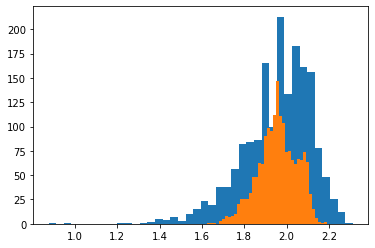

In [36]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')

(array([  2.,   4.,  17.,  34.,  53.,  64.,  70., 102.,  81.,  89.,  91.,
         84.,  74.,  73.,  76.,  55.,  56.,  51.,  48.,  41.,  26.,  30.,
         31.,  20.,  27.,  29.,  21.,  24.,  20.,  14.,  30.,  20.,  27.,
         24.,  31.,  22.,  27.,  52.,  45.,  69.]),
 array([ 8.904737 ,  9.151753 ,  9.398769 ,  9.645784 ,  9.8928   ,
        10.139816 , 10.386832 , 10.633848 , 10.880863 , 11.127879 ,
        11.374895 , 11.621911 , 11.868927 , 12.115942 , 12.362958 ,
        12.609974 , 12.85699  , 13.104006 , 13.351021 , 13.598037 ,
        13.845053 , 14.092069 , 14.339085 , 14.5861   , 14.833116 ,
        15.080132 , 15.3271475, 15.574163 , 15.821178 , 16.068195 ,
        16.31521  , 16.562225 , 16.809242 , 17.056257 , 17.303274 ,
        17.55029  , 17.797304 , 18.044321 , 18.291336 , 18.538353 ,
        18.785368 ], dtype=float32),
 <BarContainer object of 40 artists>)

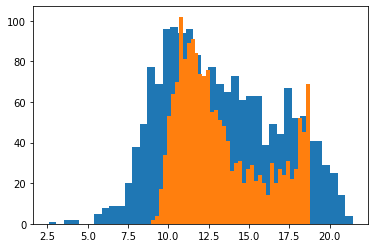

In [110]:
import matplotlib.pyplot as plt
from scipy.stats import boxcox
plt.hist(np.log1p(labels),bins=40)
plt.hist(np.log1p(preds),bins=40)

#plt.xscale('log')